# Thinking with Images Cookbook with Seed1.8

This cookbook demonstrates how to use the **Seed1.8** model to perform structured reasoning on single images — observing details, extracting key points, and synthesizing conclusions.

Instead of just returning a processed image, the API provides a comprehensive response that includes the model's reasoning, the URL to the new image, and a final textual summary.

We use the Ark Chat API with image processing enabled to encourage precise visual perception and step-by-step reasoning.

---


### 0. Prerequisites
- **API Key**: [Obtain an API key](https://console.volcengine.com/ark/region:ark+cn-beijing/apiKey) for the Seed1.8 model.
- **Model Endpoint**: Ensure the base URL of the Ark API.
- **Activate the Model**: Activate the Seed1.8 model in [the Ark Console](https://console.volcengine.com/ark/region:ark+cn-beijing/openManagement).
- **Install Dependencies**: Install required Python packages.


In [ ]:
pip install -r ../requirements.txt

In [ ]:
# Copyright 2025 Bytedance Ltd. and/or its affiliates.
# SPDX-License-Identifier: Apache-2.0

# Please set the API key here
import os

os.environ['ARK_API_KEY']  = 'your_ark_api_key'
os.environ['ARK_MODEL_ENDPOINT'] = "doubao-seed-1-8-251215"
base_url = "https://ark.cn-beijing.volces.com/api/v3"

---

### 1. Code Setup
Configure the Ark API client with image processing enabled.

What is written on the sign in front of you?


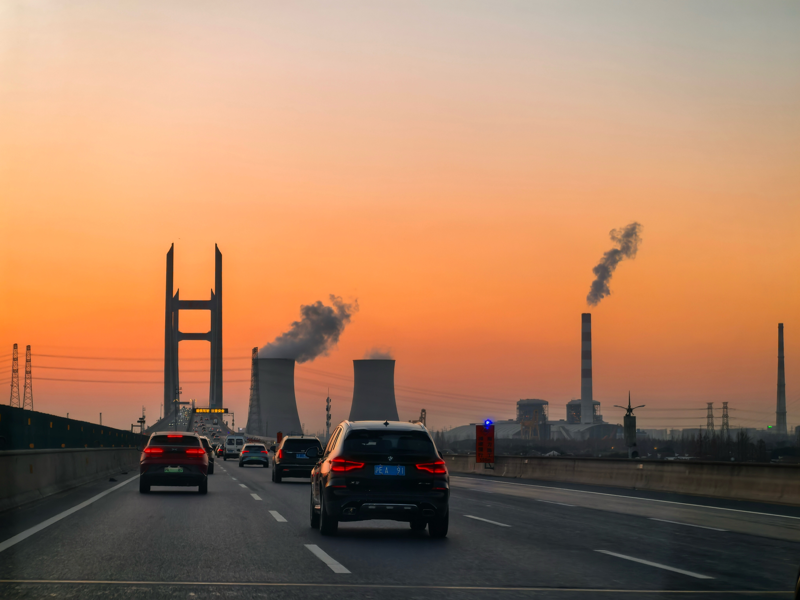

In [ ]:
# Reference: https://www.volcengine.com/docs/82379/1798161

import os
from io import BytesIO
import requests
from PIL import Image
from openai import OpenAI

client = OpenAI(
    base_url='https://ark.cn-beijing.volces.com/api/v3',
    api_key = os.getenv('ARK_API_KEY'),
    default_headers={'ark-beta-image-process': 'true'},  # Required!
)

query = [{
    'type':
        'message',
    'role':
        'user',
    'content': [{
        'type': 'input_image',
        'image_url': 'https://ark-project.tos-cn-beijing.volces.com/doc_image/image_process_1.jpg'
    }, {
        'type': 'input_text',
        'text': 'What is written on the sign in front of you?'
    }]
}]

print(query[0]['content'][1]['text'])  # print the query text
Image.open(BytesIO(requests.get(query[0]['content'][0]['image_url']).content)).resize((800, 600))  # visualize the query image


### 2. Parse the response
The API returns a list of content blocks, not a single image or text string. Iterate through this list and handle each block based on its `type`:
- **`reasoning`**: Contains the model's thought process, explaining how it interpreted the request and planned its actions.
- **`image_process`**: Provides the `result_image_url` pointing to the visually modified image (e.g., with annotations or crops). You need to download this image to display or save it.
- **`message`**: Delivers the final, user-facing text answer.

In [ ]:
response = client.responses.create(
    model=os.getenv('ARK_MODEL_ENDPOINT'),
    tools=[{
        'type': 'image_process'
    }],
    input=query,
    stream=False,
)

# print(response.output)

contents = []
for item in response.output:
    if item.type == 'reasoning':
        contents.append('<think>\n' + item.summary[0].text + '\n</think>')
    elif item.type == 'image_process':
        img = item.action['result_image_url']
        img = Image.open(BytesIO(requests.get(img).content))
        contents.append(img)
    elif item.type == 'message':
        contents.append('<answer>\n' + item.content[0].text + '\n</answer>')

print([type(c) for c in contents])

[<class 'str'>, <class 'PIL.JpegImagePlugin.JpegImageFile'>, <class 'str'>, <class 'str'>]


In [5]:
print(contents[0])

<think>
Got it, let's zoom in on the sign above the road. The bbox should be <bbox>245 679 290 692</bbox>. Let's use ZOOM tool on that area with scale 2.
</think>


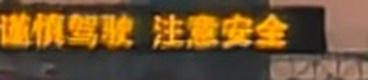

In [6]:
contents[1]

In [7]:
print(contents[2])

<think>
After zooming in, I can see the sign text: "谨慎驾驶 注意安全". Let me confirm, the text is Chinese, meaning "Drive carefully, pay attention to safety" (or more naturally, "Drive cautiously, stay safe"). Yep, that's what's written on the sign.
</think>


In [8]:
print(contents[3])

<answer>
The sign reads: **谨慎驾驶 注意安全** (which translates to "Drive cautiously, pay attention to safety" / "Drive carefully, stay safe" in English).
</answer>
